In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
import os, fnmatch
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures 
import seaborn as sns
%matplotlib inline
from keras.layers import Input, Dense
from keras.models import Model
# from keras.op
from keras import optimizers
from keras import regularizers
from PIL import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

Using TensorFlow backend.


In [2]:
class_path = "./DataCreation/Dataset/Clustering/"
data = []
data_names = os.listdir(class_path)
pattern = "*.tiff"
for entry in data_names:
    if fnmatch.fnmatch(entry, pattern):
            data.append(class_path+entry)

In [3]:
print(len(data))

2412


In [4]:
data_list = []
for i in range(len(data)):
    arr_obj = []
    cl = (data[i].split("/")[4]).split("~~~")[0]
    if cl == "Sy1" or cl == "cv" or cl == "WD" or cl == "QSO": continue
    arr_obj.append(cl)
    arr_obj.append(data[i])
    data_list.append(arr_obj)

In [5]:
print(len(data_list))

1736


In [6]:
df_data = pd.DataFrame(data_list)
df_data.head()

,0,1
0,C,./DataCreation/Dataset/Clustering/C~~~0445+010...
1,C,./DataCreation/Dataset/Clustering/C~~~0545+660...
2,C,./DataCreation/Dataset/Clustering/C~~~0606+673...
3,C,./DataCreation/Dataset/Clustering/C~~~0706+401...
4,C,./DataCreation/Dataset/Clustering/C~~~0754+721...


In [7]:
df_data[0].value_counts()

sd     707
C      425
Mrk    391
M      198
PN      15
Name: 0, dtype: int64

In [8]:
X_tr = df_data.iloc[:, 1]
Y_tr = df_data.iloc[:, 0]
X_tr = X_tr.values
Y_tr = Y_tr.values

In [9]:
images_list = []
max_width = 0
max_height = 0
ind = 0
for i in range(len(X_tr)):
    im = Image.open(X_tr[i])
    arr = np.array(im)#.flatten()
    
    arr=(arr-arr.min())/(arr.max()-arr.min())
    #arr = arr / 0xffff
    s = arr.shape
    if s[0] > max_height:
        max_height = s[0]
    if s[1] > max_width:
        max_width = s[1]
        ind = i
    images_list.append(arr)

In [10]:
print(max_width, max_height)

40 140


In [11]:
for i in range(len(images_list)):
    s = images_list[i].shape
    d_width = (max_width - s[1])
    d_height = (max_height - s[0])
    
    d_top = int(d_height / 2)
    d_bottom = int(d_height - d_top)
    
    d_left = int(d_width / 2)
    d_right = int(d_width - d_left)
    #print(d_top, d_bottom, d_left, d_right)
    
    arr = images_list[i]
    for l in range(d_left):
        arr = np.insert(arr, 0, 0, axis = 1)
    
    for r in range(d_right):
        b = np.zeros((s[0],1))
        arr = np.append(arr, b, axis = 1)
    
    for t in range(d_top):
        arr = np.insert(arr, 0, 0, axis = 0)
    
    for b in range(d_bottom):
        b = np.zeros((1, arr.shape[1],))
        arr = np.append(arr, b, axis = 0)
    
    images_list[i] = arr.flatten()

40 140


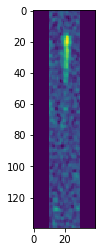

In [12]:
width = max_width
height = max_height
print(width, height)
plt.imshow(images_list[1000].reshape(140, 40))

In [13]:
from scipy.ndimage.filters import gaussian_filter

for i in range(len(images_list)):
    images_list[i] = gaussian_filter(images_list[i], sigma=2)
#for i in range(len(images_list)):
#    images_list[i] = np.gradient(images_list[i], axis = 0)

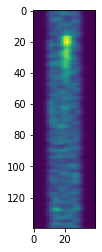

In [14]:
plt.imshow(images_list[1000].reshape(140, 40))

In [15]:
images_np = np.array(images_list)
X_train, X_test = train_test_split(images_np, test_size=0.2, random_state=100)

In [16]:
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (1388, 5600)
1388 train samples
348 test samples


In [17]:
X_train = X_train.reshape(1388, 140, 40, 1)

In [18]:
X_test = X_test.reshape(348, 140, 40, 1)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
input_img = Input(shape=(height, width, 1))
x = Conv2D(128, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 1))(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((1, 1))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((1, 1))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((5, 2))(x)
l = Flatten()(x)
l = Dense(280, activation='relu')(l)

d = Reshape((14,20,1))(l)
x = Conv2D(64, (3, 3), padding='same')(d)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((5, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((1, 1))(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((1 , 1))(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 1))(x)
x = Conv2D(1, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('relu')(x)

##ENCODER
#inp = Input(shape=(height, width, 1))
#e = Conv2D(32, (3, 3), activation='relu')(inp)
#e = MaxPooling2D((2, 2))(e)
#e = Conv2D(64, (3, 3), activation='relu')(e)
#e = MaxPooling2D((2, 2))(e)
#e = Conv2D(64, (3, 3), activation='relu')(e)
#l = Flatten()(e)
#l = Dense(49, activation='softmax')(l)
##DECODER
#d = Reshape((7,7,1))(l)
#d = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(d)
#d = BatchNormalization()(d)
#d = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(d)
#d = BatchNormalization()(d)
#d = Conv2DTranspose(32,(3, 3), activation='relu', padding='same')(d)
#decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)
#ae = Model(inp, decoded)
#ae.summary()

In [20]:
model = Model(input_img, decoded)
adadelta = optimizers.Adadelta(lr=0.1, rho=0.95)
model.compile(optimizer= adadelta, loss='MSE')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140, 40, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 140, 40, 128)      1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 140, 40, 128)      512       
_________________________________________________________________
activation_1 (Activation)    (None, 140, 40, 128)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 70, 40, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 40, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 70, 40, 128)       512       
_________

In [25]:
history = model.fit(X_train, X_train,
                    batch_size=16,
                    epochs=30,
                    validation_data=(X_test, X_test),
                    shuffle=True)

Train on 1388 samples, validate on 348 samples
Epoch 1/30
1388/1388 [==============================] - 19s 14ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 2/30
1388/1388 [==============================] - 19s 14ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 3/30
1388/1388 [==============================] - 19s 14ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/30
1388/1388 [==============================] - 19s 14ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/30
1388/1388 [==============================] - 19s 14ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/30
1388/1388 [==============================] - 19s 14ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/30
1388/1388 [==============================] - 19s 14ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/30
1388/1388 [==============================] - 19s 14ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/30
1388/1388 [==============================] - 19s 14ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/30
1388/

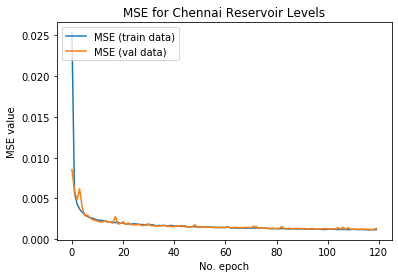

In [22]:
plt.plot(history.history['loss'], label='MSE (train data)')
plt.plot(history.history['val_loss'], label='MSE (val data)')
plt.title('MSE for Chennai Reservoir Levels')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

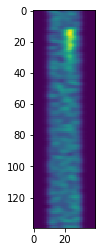

In [23]:
test_img = X_test[156].reshape(140, 40)
plt.imshow(test_img)

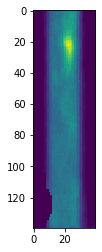

In [24]:
result_img = model.predict(X_test[156].reshape(1, 140, 40, 1))
plt.imshow(result_img.reshape(140, 40))

In [58]:
images_np.shape

(1736, 140, 40, 1)

In [59]:
images_np = images_np.reshape(1736, 140, 40, 1)

In [60]:
model_encoder = Model(input_img, l)

In [61]:
encoded_values = model_encoder.predict(images_np)

In [62]:
encoded_values.shape

(1736, 140)

In [63]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
X = encoded_values
db = DBSCAN(eps=1, min_samples=2).fit(X)

In [64]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

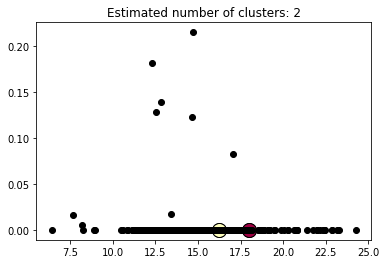

In [65]:


# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [66]:
Sum_of_squared_distances = []
K = range(1,6)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

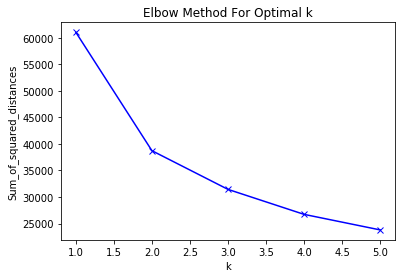

In [67]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()